1/1 [==============================] - 0s 29ms/step


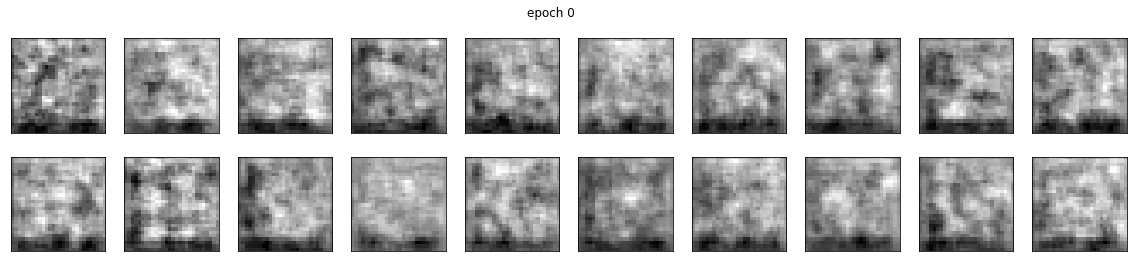

1/1 [==============================] - 0s 29ms/step


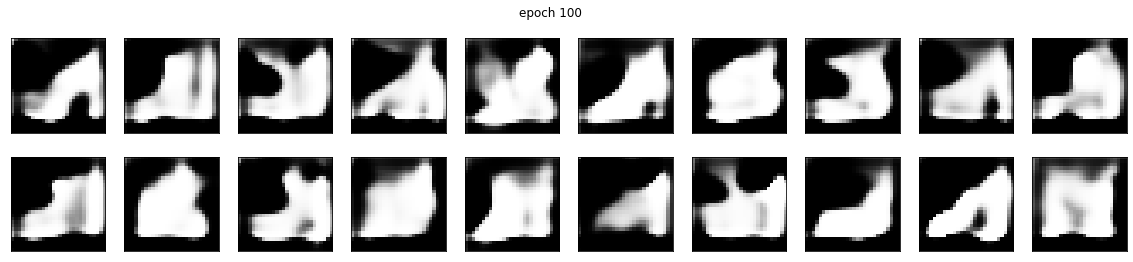

1/1 [==============================] - 0s 32ms/step


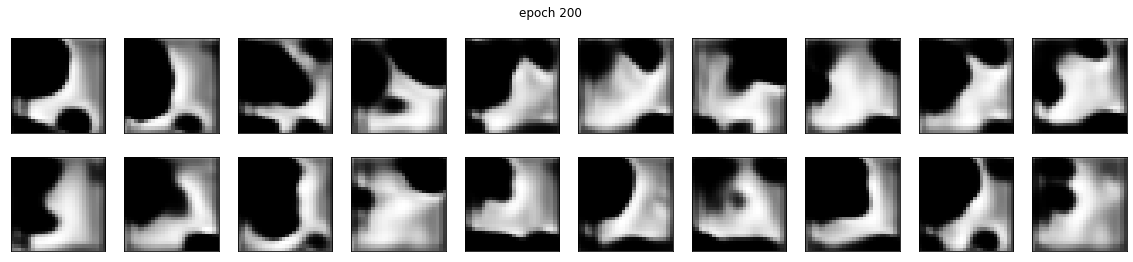

1/1 [==============================] - 0s 32ms/step


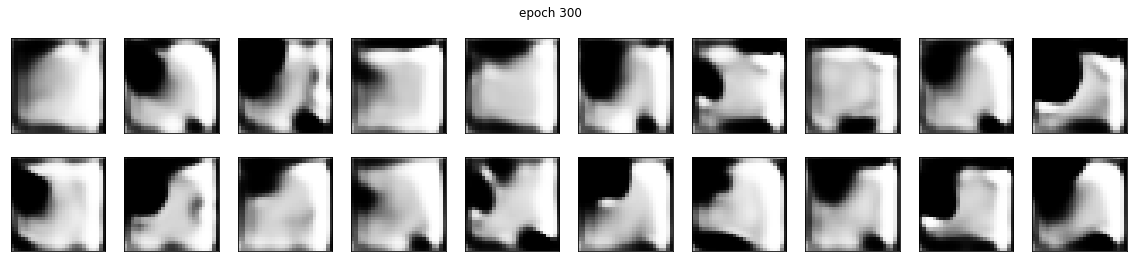

1/1 [==============================] - 0s 35ms/step


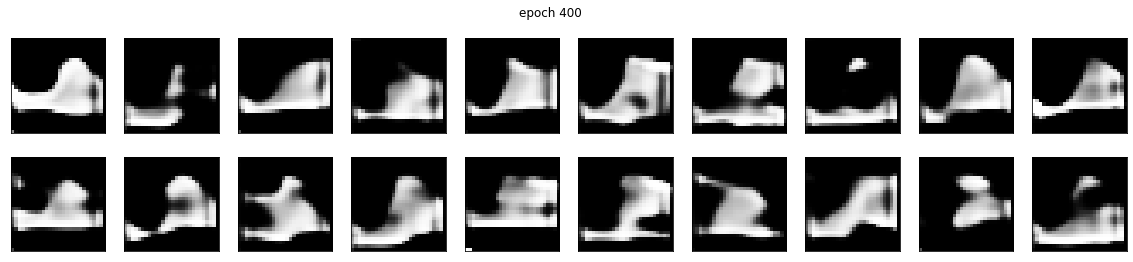

1/1 [==============================] - 0s 30ms/step


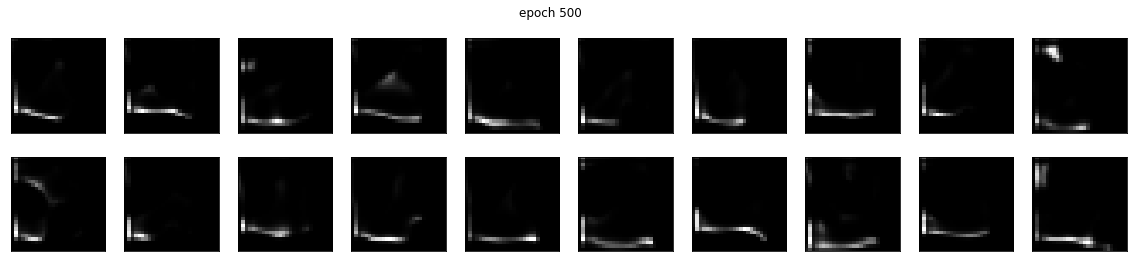

1/1 [==============================] - 0s 34ms/step


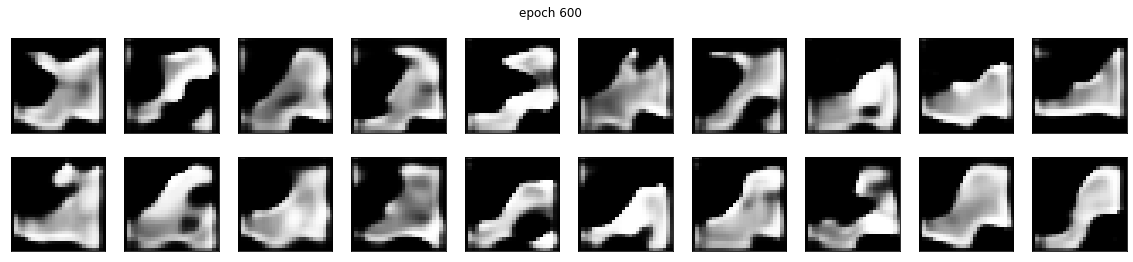

1/1 [==============================] - 0s 30ms/step


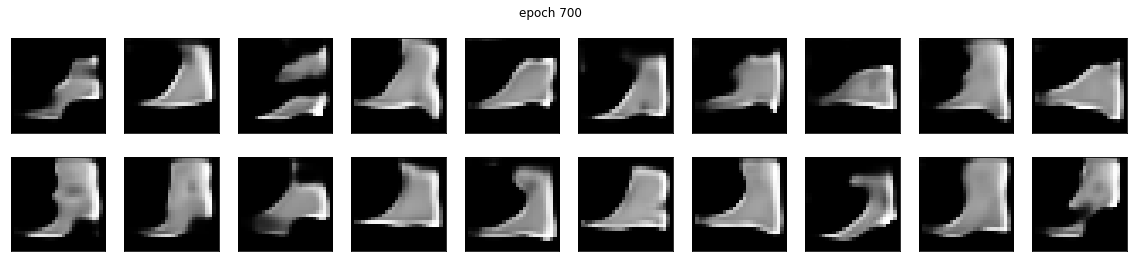

1/1 [==============================] - 0s 29ms/step


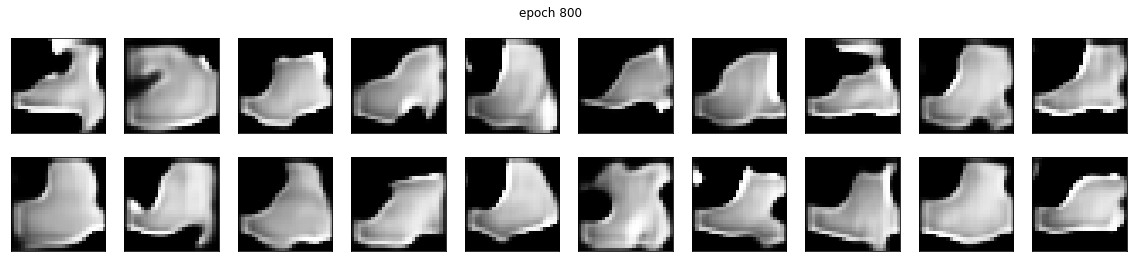

1/1 [==============================] - 0s 31ms/step


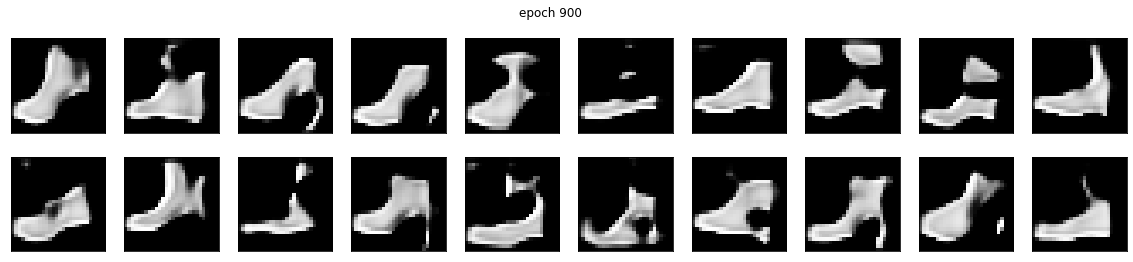

1/1 [==============================] - 0s 29ms/step


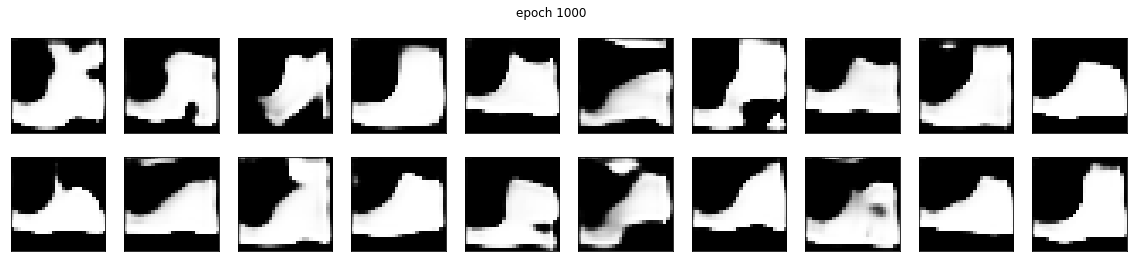

1/1 [==============================] - 0s 35ms/step


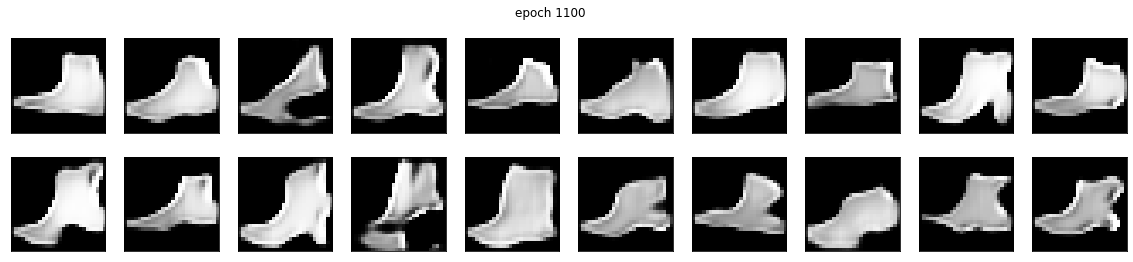

1/1 [==============================] - 0s 30ms/step


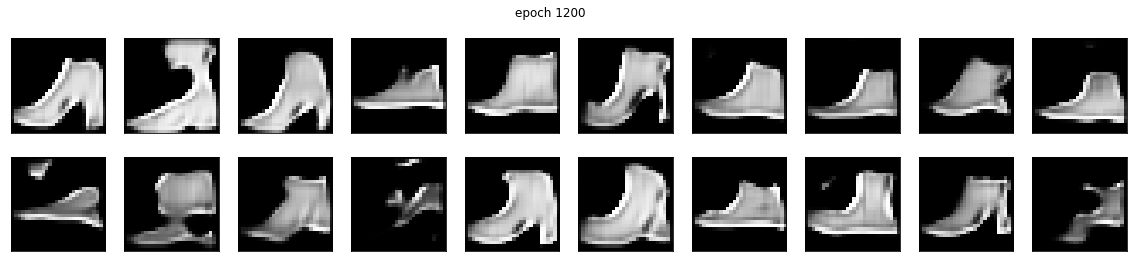

1/1 [==============================] - 0s 36ms/step


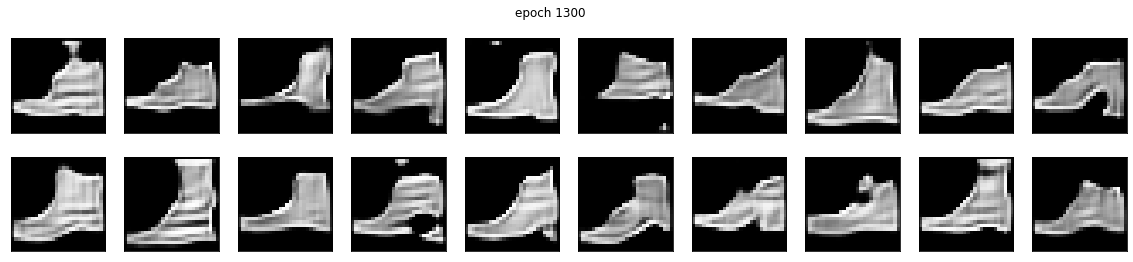

1/1 [==============================] - 0s 32ms/step


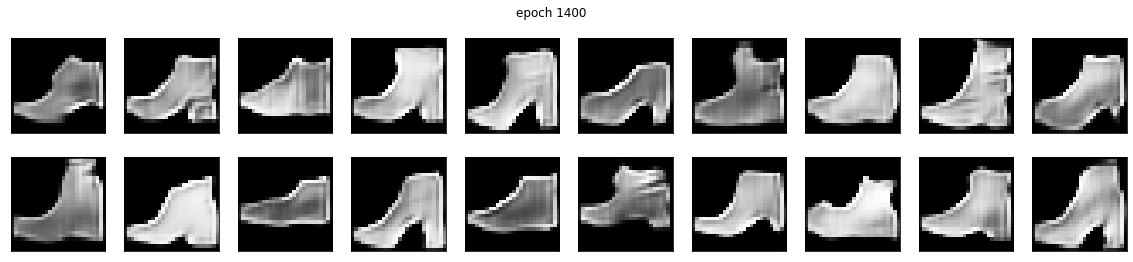

1/1 [==============================] - 0s 29ms/step


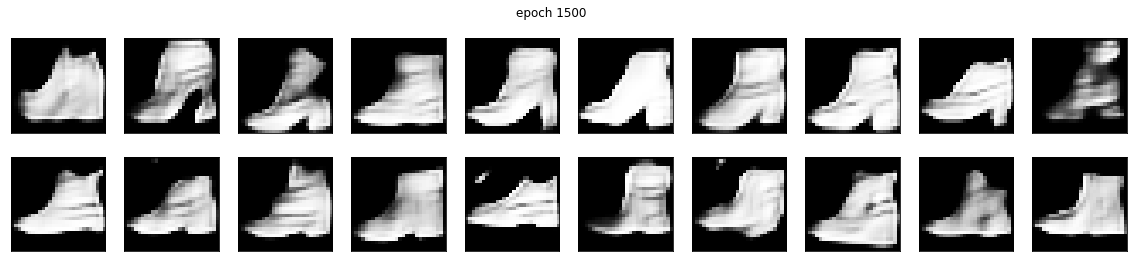

1/1 [==============================] - 0s 35ms/step


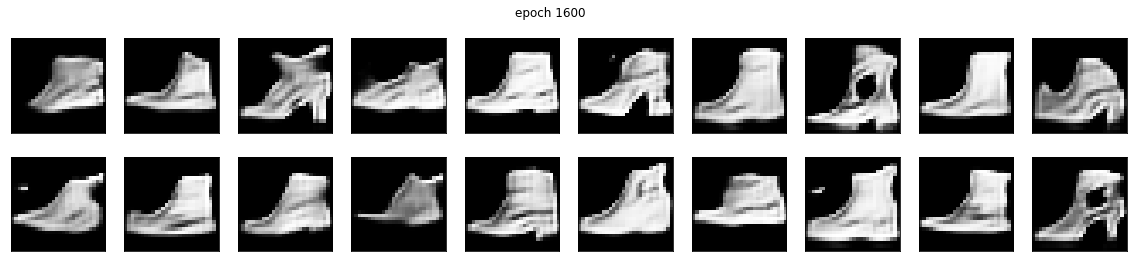

1/1 [==============================] - 0s 31ms/step


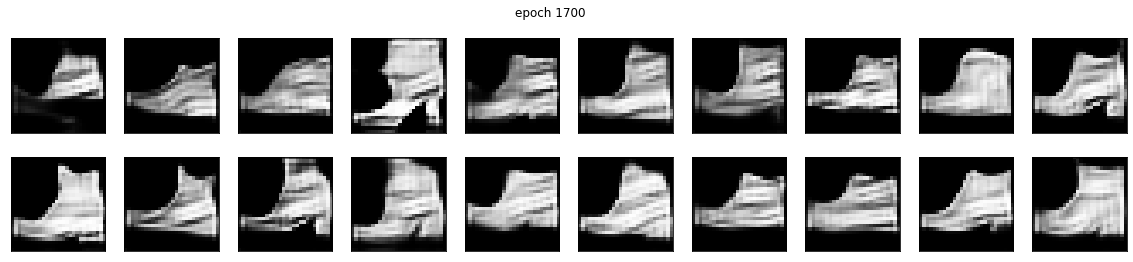

1/1 [==============================] - 0s 30ms/step


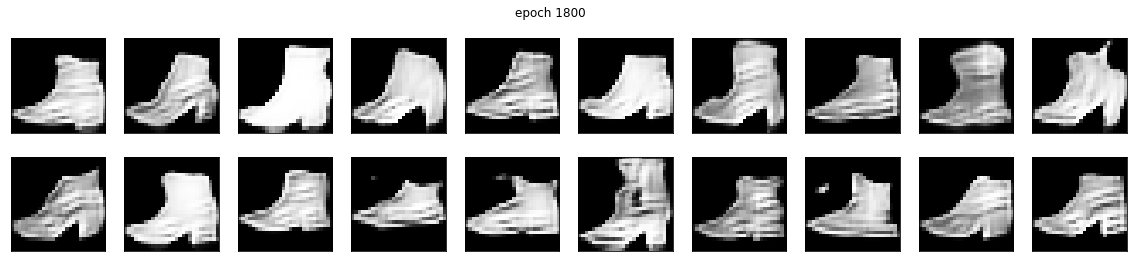

1/1 [==============================] - 0s 30ms/step


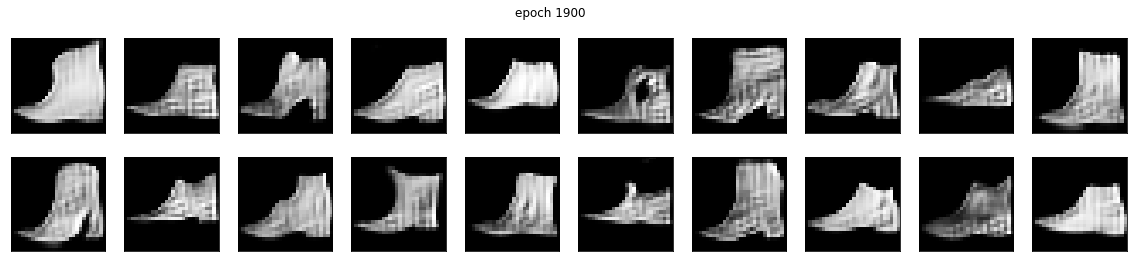

1/1 [==============================] - 0s 31ms/step


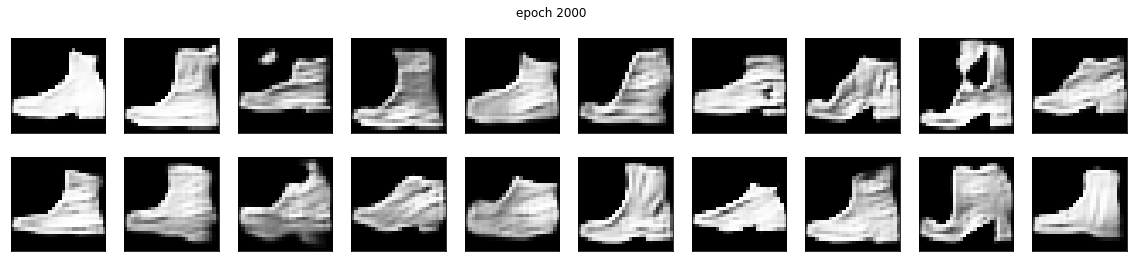

1/1 [==============================] - 0s 34ms/step


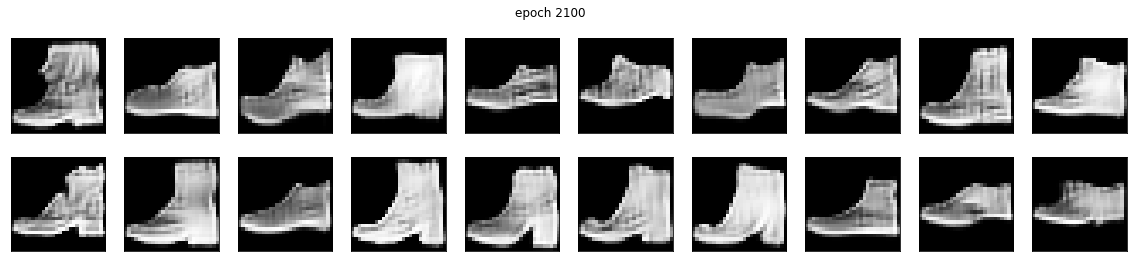

1/1 [==============================] - 0s 32ms/step


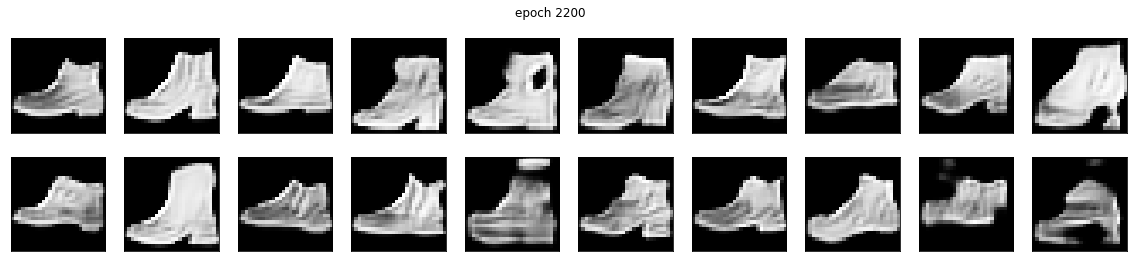

1/1 [==============================] - 0s 29ms/step


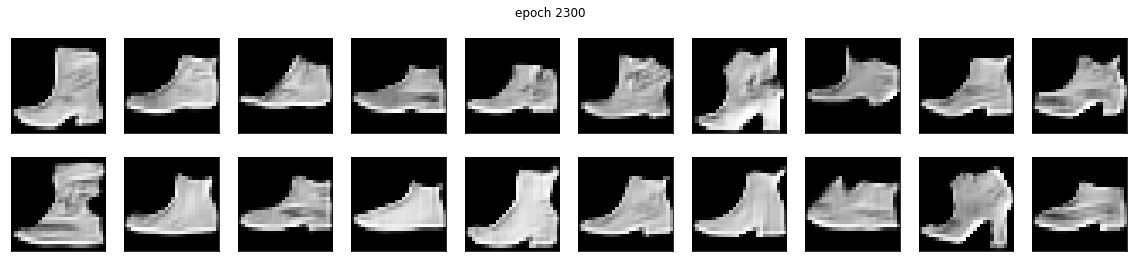

1/1 [==============================] - 0s 40ms/step


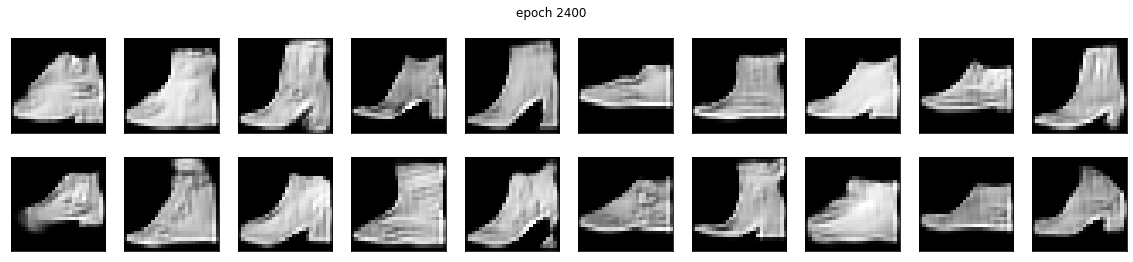

1/1 [==============================] - 0s 30ms/step


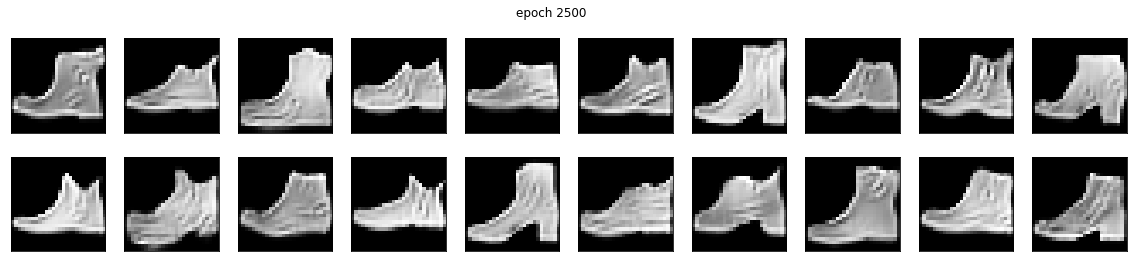

1/1 [==============================] - 0s 30ms/step


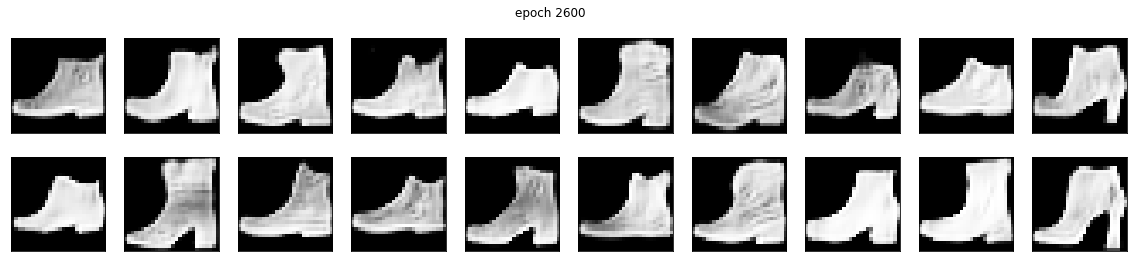

1/1 [==============================] - 0s 30ms/step


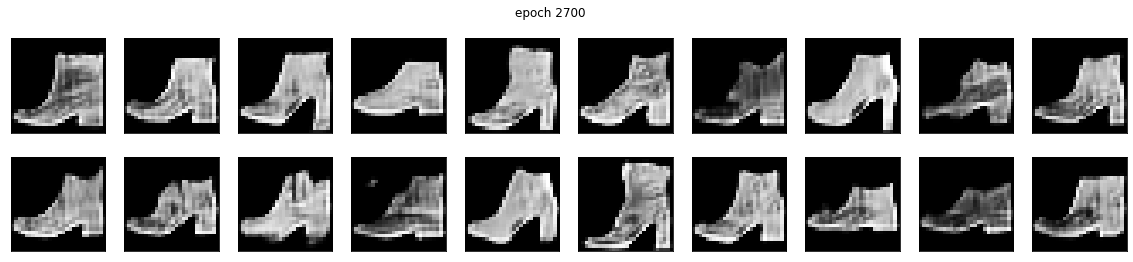

1/1 [==============================] - 0s 30ms/step


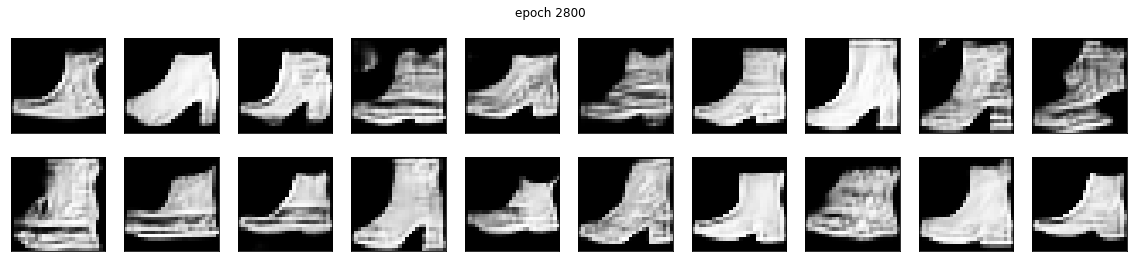

1/1 [==============================] - 0s 33ms/step


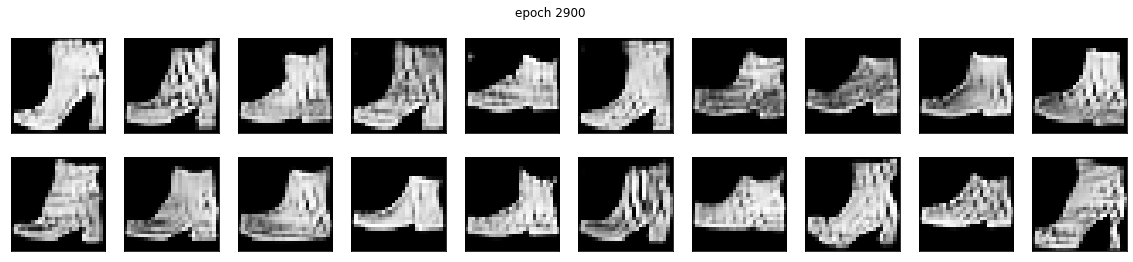

1/1 [==============================] - 0s 30ms/step


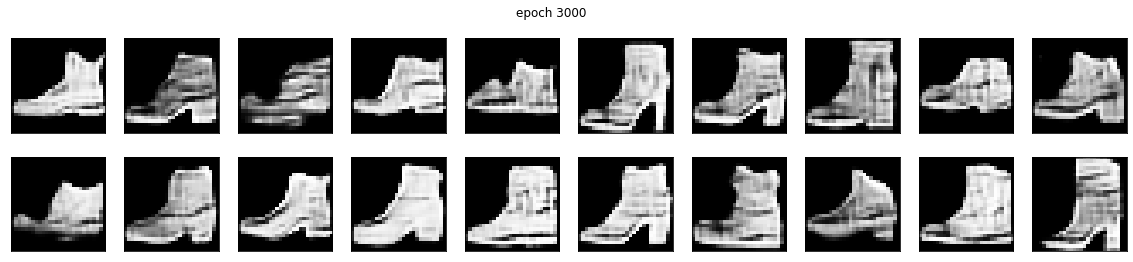

1/1 [==============================] - 0s 30ms/step


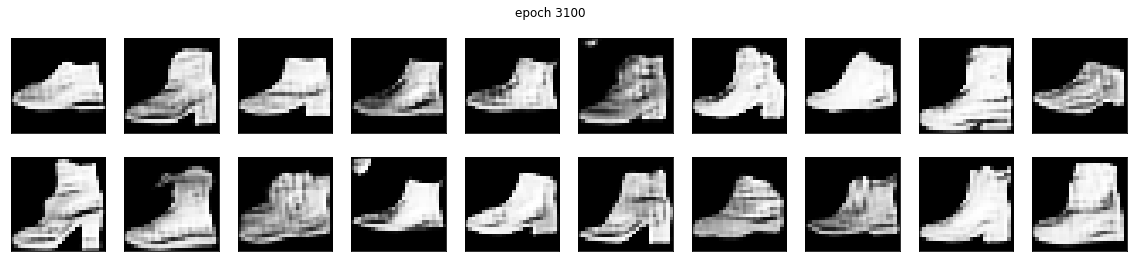

1/1 [==============================] - 0s 32ms/step


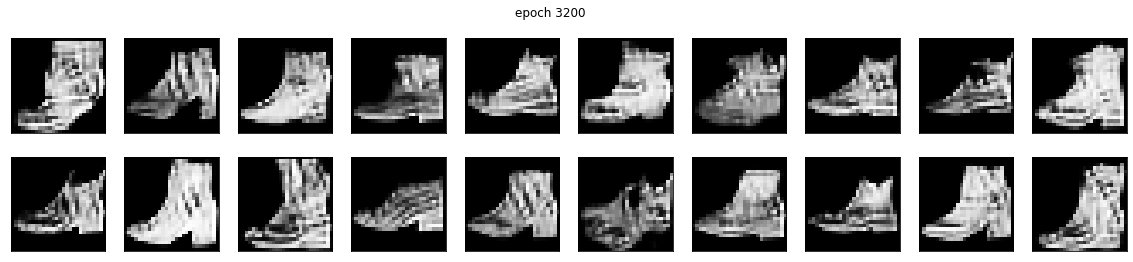

1/1 [==============================] - 0s 38ms/step


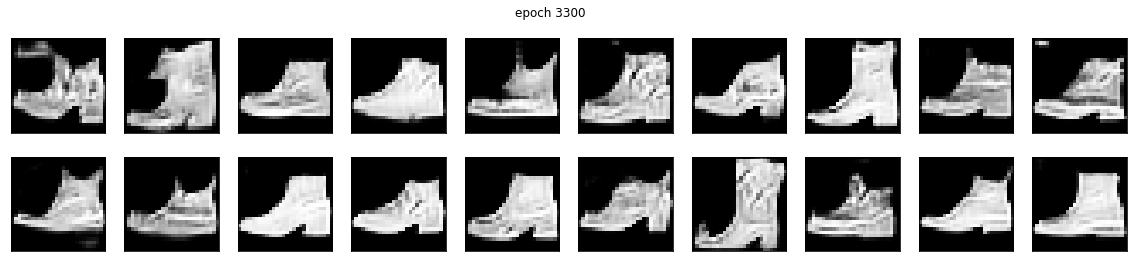

1/1 [==============================] - 0s 31ms/step


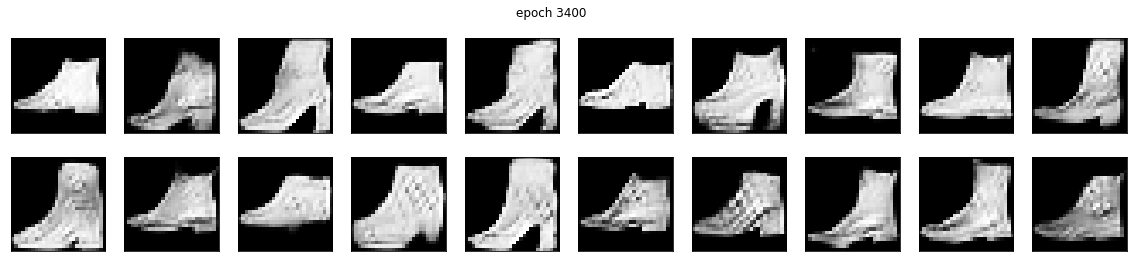

1/1 [==============================] - 0s 30ms/step


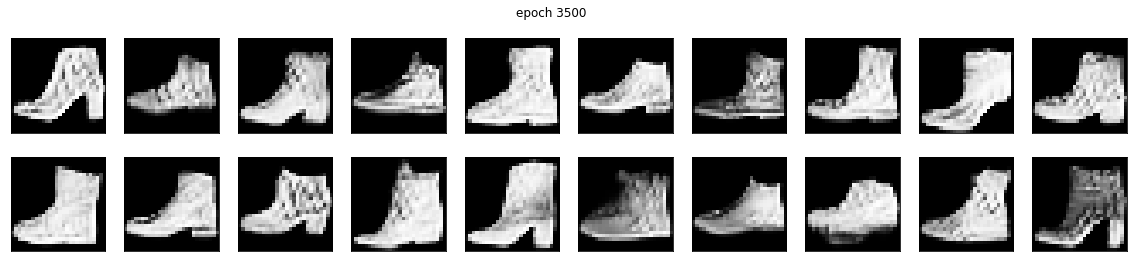

2/2 [==============================] - 1s 363ms/step


KeyboardInterrupt: ignored

In [1]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Input,Activation,Dense,Flatten,Reshape,Conv2D,Conv2DTranspose,Dropout,BatchNormalization,UpSampling2D,LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse
import matplotlib.pyplot as plt

(x_train,y_train),(x_test,y_test)=fashion_mnist.load_data()
x_train=x_train[np.isin(y_train,[9])] # 9번 부류는 ankle boot
x_train = (x_train.astype('float32')/255.0)*2.0-1.0 # [-1,1] 구간
x_test = (x_test.astype('float32')/255.0)*2.0-1.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

batch_siz=64
epochs=5000
dropout_rate=0.4
batch_norm=0.9
zdim=100 # 잠복 공간의 차원

discriminator_input=Input(shape=(28, 28, 1)) # 분별망 D 설계
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(discriminator_input)
x=Dropout(dropout_rate)(x)
x=Conv2D(64,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(2,2))(x)
x=Dropout(dropout_rate)(x)
x=Conv2D(128,(5,5),activation='relu',padding='same',strides=(1,1))(x)
x=Dropout(dropout_rate)(x)
x=Flatten()(x)
discriminator_output=Dense(1,activation='sigmoid')(x)
discriminator=Model(discriminator_input,discriminator_output)

generator_input=Input(shape=(zdim,)) # 생성망 G 설계
x=Dense(3136)(generator_input)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Reshape((7,7,64))(x)
x=UpSampling2D()(x)
x=Conv2D(128,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=UpSampling2D()(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(64,(5,5),padding='same')(x)
x=BatchNormalization(momentum=batch_norm)(x)
x=Activation('relu')(x)
x=Conv2D(1,(5,5),activation='tanh',padding='same')(x)
generator_output=x
generator=Model(generator_input,generator_output)

discriminator.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

discriminator.trainable=False
gan_input=Input(shape=(zdim,))
gan_output=discriminator(generator(gan_input))
gan=Model(gan_input,gan_output)
gan.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

def train_discriminator(x_train):
    c=np.random.randint(0,x_train.shape[0],batch_siz)
    real=x_train[c]
    discriminator.train_on_batch(real,np.ones((batch_siz,1)))

    p=np.random.normal(0,1,(batch_siz,zdim))
    fake=generator.predict(p)
    discriminator.train_on_batch(fake,np.zeros((batch_siz,1)))

def train_generator():
    p=np.random.normal(0,1,(batch_siz,zdim))
    gan.train_on_batch(p,np.ones((batch_siz,1)))  # 가짜 샘플에 레이블 1붙여서 분별망이 1을 출력하게 학습한다.(분별망을 속이는 학습)

for i in range(epochs+1): # 학습을 수행
    train_discriminator(x_train)
    train_generator()
    if(i%100==0): # 학습 도중 100세대마다 중간 상황 출력
        plt.figure(figsize=(20, 4))
        plt.suptitle('epoch '+str(i))
        for k in range(20):
            plt.subplot(2,10,k+1)
            img=generator.predict(np.random.normal(0,1,(1,zdim)))
            plt.imshow(img[0].reshape(28,28),cmap='gray')
            plt.xticks([]); plt.yticks([])
        plt.show()

imgs=generator.predict(np.random.normal(0,1,(50,zdim)))
plt.figure(figsize=(20,10)) # 학습을 마친 후 50개 샘플을 생성하여 출력
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(imgs[i].reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
    
# 훈련 집합 x_train에서 img와 가장 가까운 영상을 찾아주는 함수
def most_similar(img,x_train):
    vmin=1.0e10
    for i in range(len(x_train)):
        dist=np.mean(np.abs(img-x_train[i]))
        if dist<vmin:
            imin,vmin=i,dist
        return x_train[imin]

# 50개의 영상에 대해 가장 가까운 영상을 찾아 보여줌
plt.figure(figsize=(20,10))
for k in range(50):
    plt.subplot(5,10,k+1)
    plt.imshow(most_similar(imgs[k],x_train).reshape(28,28),cmap='gray')
    plt.xticks([]); plt.yticks([])
plt.show()